# Two coupled Duffing Oscillators

In [1]:
using DrWatson # a scientific project assistant package. It helps managing scientific projects, e.g., reproducibility, data analysis, etc.
@quickactivate "KerrDimer"

using HarmonicBalance; HB = HarmonicBalance # A package for solving the complete solution space of nonlinear oscillatros
using Symbolics
import HarmonicBalance.LinearResponse.plot_linear_response # The linear reponse module of HB

using Plots, Measures # Plotting tools
using Logging; Logging.disable_logging(Logging.Warn); # Gets rid of the annoying "Warning: non-negligible complex parts have been projected on the real axis" message

Base.atan(v::ComplexF64, u::ComplexF64) = atan(real(v), real(u)) # To make a phase plot
# ^ the solutions of the HB method are of the type ComplexF64 (only the real are physical). This is a quick fix.

## The equations

\begin{equation}

\end{equation}

### Mean-field

In [2]:
# defining variables
@variables αᵣ₁::Real, αᵢ₁::Real, αᵣ₂::Real, αᵢ₂::Real
@variables κ₁::Real, κ₂::Real, F_1::Real, J::Real , ω_1::Real, ω_2::Real, U_1::Real, U_2::Real, ω_p::Real 
@variables α₁::Complex{Real}, α₂::Complex{Real}

# accounting for the fact that we "divide" each complex equation in its real and imaginary part
function replace_split(f,sub_rules)
    exp = substitute(real(f),sub_rules) + 1.0im*substitute(imag(f),sub_rules)
    [real(exp), imag(exp)]
end

function get_EOM_full()
    K₁ = (-(ω_p-ω_1) + U_1*conj(α₁)*α₁ - 1.0im*κ₁/2)*α₁ + F_1
    #*sqrt(U)
    K₂ = (-(ω_p-ω_2) + U_2*conj(α₂)*α₂ - 1.0im*κ₂/2)*α₂ 
    
    fψ₁ =   -1.0im*(K₁ - J*α₂) 
    fψ₂ =   -1.0im*(K₂ - J*α₁) 
    
    sub_rules = Dict((real(α₁)=>αᵣ₁), (imag(α₁)=>αᵢ₁), (real(α₂)=>αᵣ₂), (imag(α₂)=>αᵢ₂))

    variables = [αᵣ₁, αᵢ₁, αᵣ₂, αᵢ₂]
    parameters = [ω_1, ω_2, ω_p, U_1, U_2, F_1, J, κ₁, κ₂]
    system_f= reduce(vcat,[replace_split(f,sub_rules) for f in [fψ₁,fψ₂]])

    equation_HC = HarmonicBalance.Problem(system_f,variables,parameters);
    return equation_HC
end

MF_eqs = get_EOM_full();

Hot fix required for the eom field in the harmonic equations object to not be empty. Will be corrected in future versions

In [3]:
# declare dummy system: declare constant variables and two functions x(t) and y(t)
@variables α, ω, ω0, t, η, x(t), y(t)

# differential equations
diff_eq = DifferentialEquation([d(x,t,2) + ω0^2*x ~ 0,
                                d(y,t,2) + ω0^2*y ~ 0], [x,y])

# specify the harmonic ansatz for x and y: x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diff_eq, x, ω)
add_harmonic!(diff_eq, y, ω)

# implement ansatz to get harmonic equations
harmonic_eq_dummy = get_harmonic_equations(diff_eq)

MF_eqs.eom = harmonic_eq_dummy;
MF_eqs.system;

## Parameter set #1

In [4]:
MF_eqs.system.expressions

4-element Vector{HomotopyContinuation.ModelKit.Expression}:
       -J*αᵢ₂ - 0.5*κ₁*αᵣ₁ + (ω_1 - ω_p + U_1*αᵢ₁^2 + U_1*αᵣ₁^2)*αᵢ₁
 -F_1 + J*αᵣ₂ - 0.5*κ₁*αᵢ₁ - (ω_1 - ω_p + U_1*αᵢ₁^2 + U_1*αᵣ₁^2)*αᵣ₁
       -J*αᵢ₁ - 0.5*κ₂*αᵣ₂ + (ω_2 - ω_p + U_2*αᵢ₂^2 + U_2*αᵣ₂^2)*αᵢ₂
       J*αᵣ₁ - 0.5*κ₂*αᵢ₂ + (-ω_2 + ω_p - U_2*αᵢ₂^2 - U_2*αᵣ₂^2)*αᵣ₂

In [ ]:
## Experimental parameters
omega_1_exp = 7270; omega_2_exp = 7304
kappa_1_exp = 14.; kappa_2_exp = 14.2
U_1_exp = -6; U_2_exp = -6
x1_min_exp=2*pi*7000; x1_max_exp=2*pi*7200
kappa_exp=0.5; J_exp=36.4;

In [6]:
## Dimensional parameters
@show omega_1 = omega_1_exp/omega_1_exp
@show omega_2 = omega_2_exp/omega_1_exp
@show U_1_val = U_1_exp/omega_1_exp
@show U_2_val = U_2_exp/omega_1_exp
@show kappa_1 = kappa_1_exp/omega_1_exp
@show kappa_2 = kappa_2_exp/omega_1_exp
# x1_min = x1_min_exp/omega_1_exp
# x1_max =x1_max_exp/omega_1_exp
@show J_val = J_exp/omega_1_exp;

omega_1 = omega_1_exp / omega_1_exp = 1.0
omega_2 = omega_2_exp / omega_1_exp = 1.0045019696117052
U_1_val = U_1_exp / omega_1_exp = -0.0001343457595035695
U_2_val = U_2_exp / omega_1_exp = -0.0001343457595035695
kappa_1 = kappa_1_exp / omega_1_exp = 4.254282384279701e-5
kappa_2 = kappa_2_exp / omega_1_exp = 3.1347343884166216e-5
J_val = J_exp / omega_1_exp = 0.0008150309409883217


### Bifurcation diagram

In [7]:
fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val)
varied = (ω_p=> range(0.985, 1.01, 100), F_1 => 10 .^range(-5, -1, 100))

# results
result_ωF = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

Computing mixed cells... 2 	 Time: 0:00:01
  mixed_volume:  24

Computing mixed cells... 7 	 Time: 0:00:01
  mixed_volume:  81

A steady state result for 10000 parameter points

Solution branches:   9
   of which real:    9
   of which stable:  6

Classes: stable, physical, Hopf, binary_labels


In [8]:
# p1 = plot_phase_diagram(result, title="all", clim =(0,5), yaxis=:log)
# p2 = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:log)
# p3 = plot_phase_diagram(result, not_class="stable", title="unstable", clim =(0,5), yaxis=:log)
# p_MF = plot([p1,p2,p3]..., layout = (1,3), size = (1200,250), margin = 5mm)

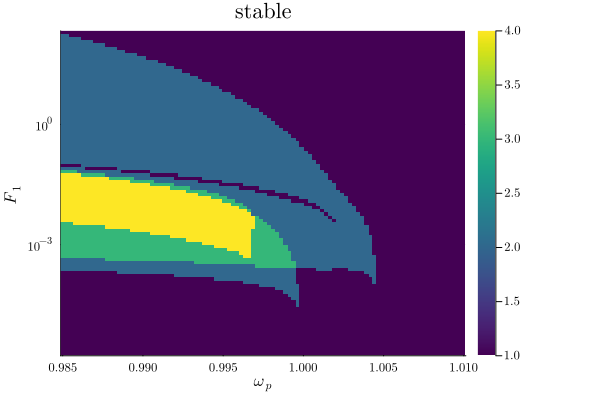

In [9]:
fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val)
varied = (ω_p=> range(0.985, 1.01, 100), F_1 => 14 .^range(-5, 2, 100))

# results
result_tmp = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

plot_phase_diagram(result_tmp, class="stable", title="stable", yaxis=:log)

### Amplitude plot

#### linear

In [10]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:linear);

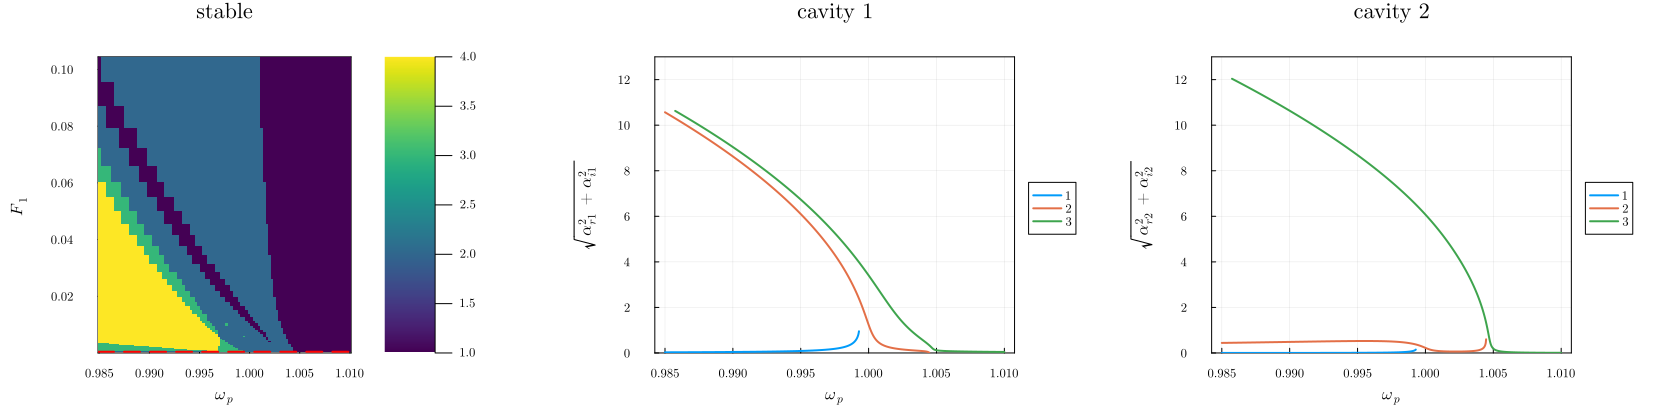

In [11]:
f_cut = 0.00044; yscale = :linear; class = "stable"; ymax = 13

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(0.985, 1.01, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1")
p3 = plot(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

[Antiresoncance](https://en.wikipedia.org/wiki/Antiresonance)

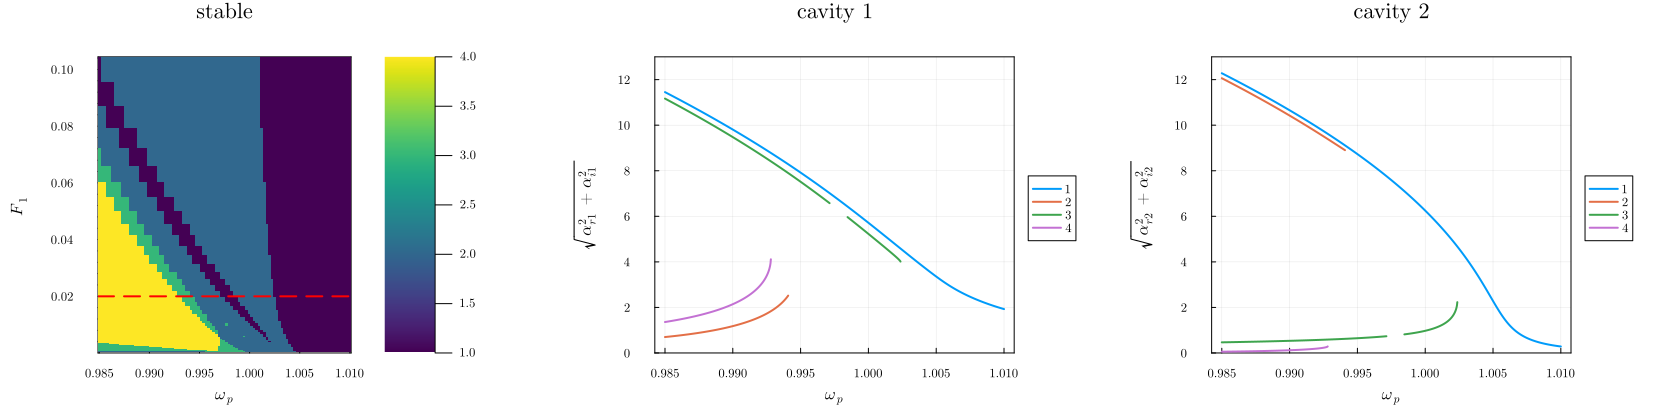

In [12]:
f_cut = 2*10^-2; yscale = :linear; class = "stable"; ymax=13

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(0.985, 1.01, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box, yminorticks=true)
p2 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1")
p3 = plot(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

#### log

In [13]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:log);

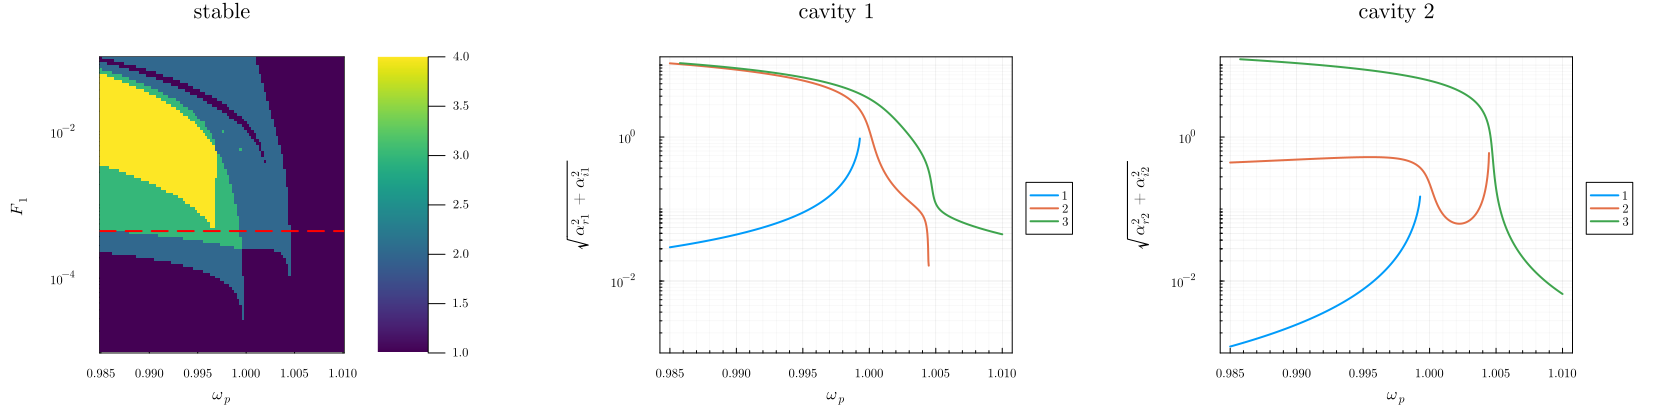

In [14]:
f_cut = 0.00044; yscale = :log10; class = "stable"; ymax = 13

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(0.985, 1.01, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box, yminorticks=10)
p2 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-3,ymax), yminorticks=10, minorgrid=true, title="cavity 1")
p3 = plot(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-3,ymax), yminorticks=10, minorgrid=true, title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

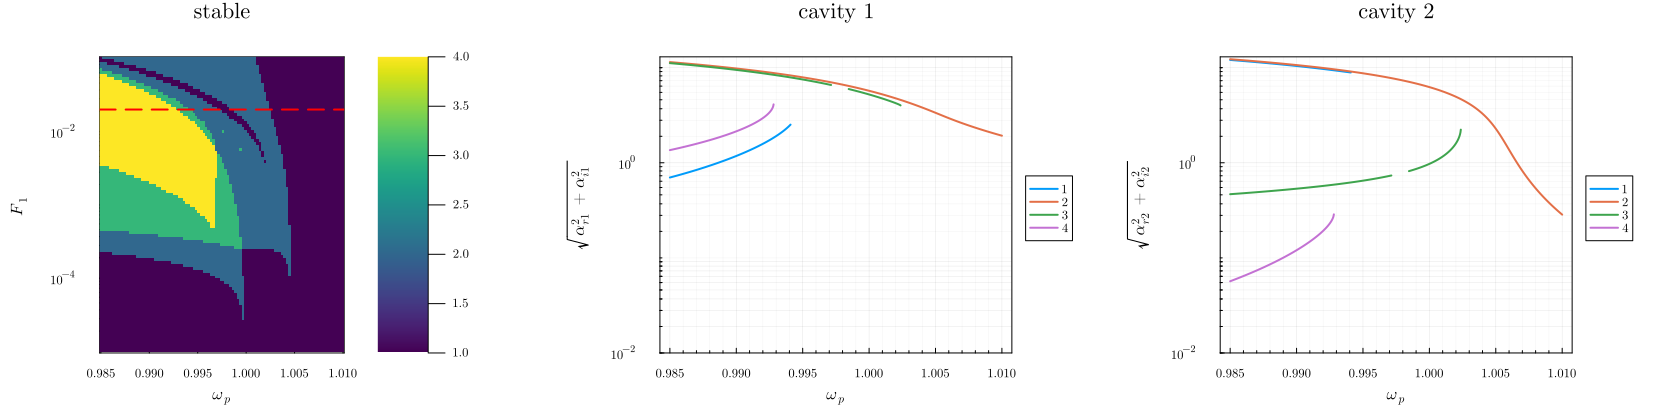

In [15]:
f_cut = 2*10^-2; yscale = :log; class = "stable"; ymax=13

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(0.985, 1.01, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box, yminorticks=10)
p2 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-2,ymax), yminorticks=10, minorgrid=true, title="cavity 1")
p3 = plot(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-2,ymax), yminorticks=10, minorgrid=true, title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

### Phase plot

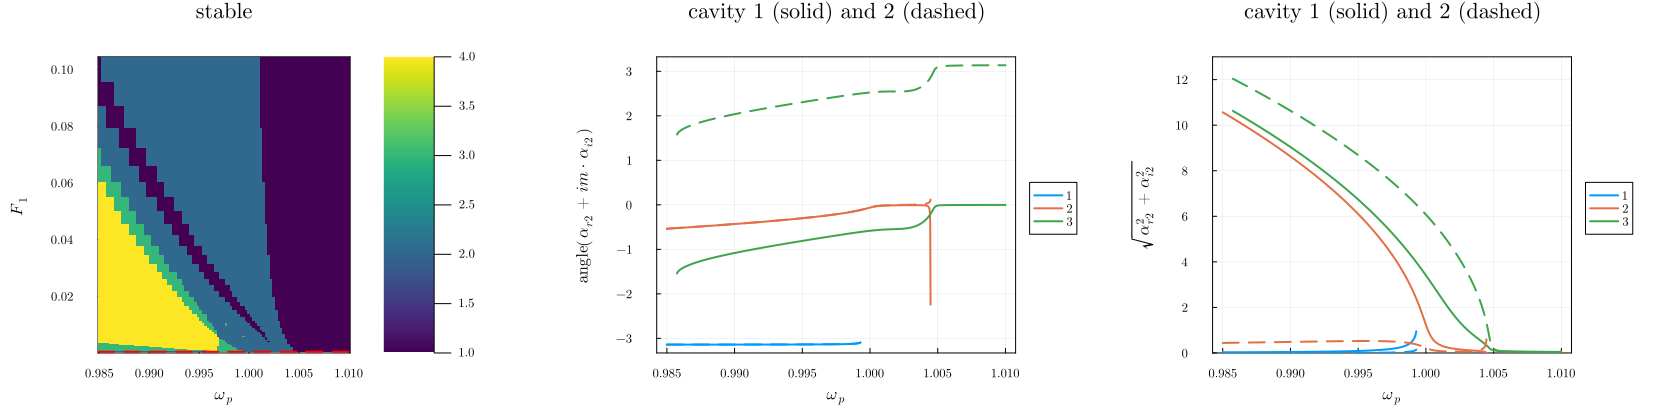

In [16]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:linear);
f_cut = 0.00044; yscale = :linear; class = "stable"

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(0.985, 1.01, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "angle(αᵣ₁+im*αᵢ₁)", class=class, yscale=yscale, framestyle = :box, title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "angle(αᵣ₂+im*αᵢ₂)", class=class, yscale=yscale, framestyle = :box, linestyle=:dash)
p3 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), linestyle=:dash)
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

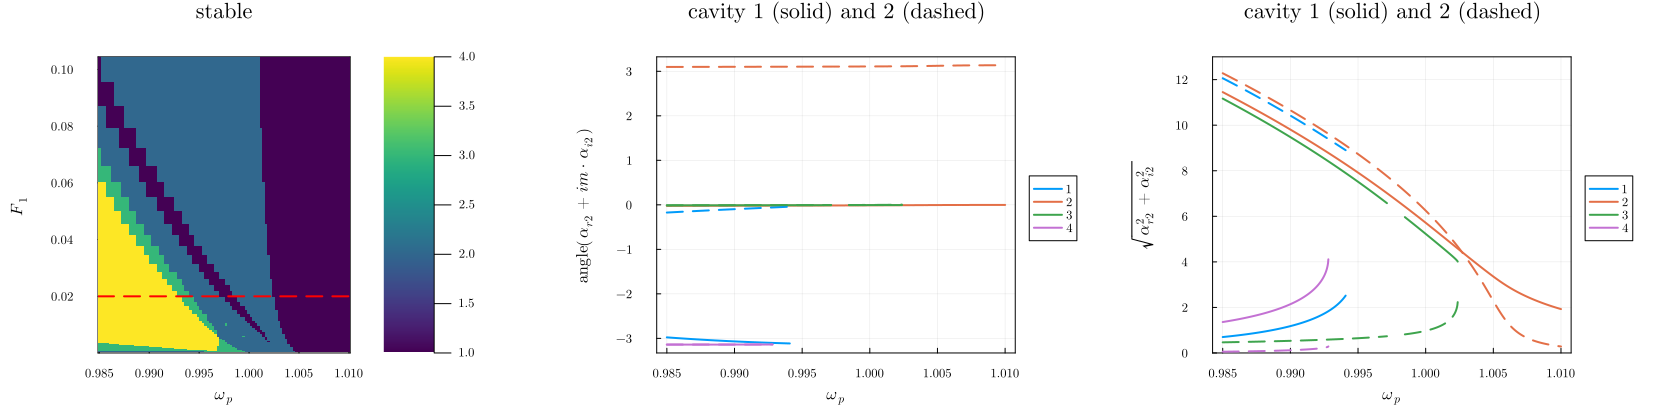

In [17]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:linear);
f_cut = 2*10^-2; yscale = :linear; class = "stable"

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(0.985, 1.01, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "angle(αᵣ₁+im*αᵢ₁)", class=class, yscale=yscale, framestyle = :box, title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "angle(αᵣ₂+im*αᵢ₂)", class=class, yscale=yscale, framestyle = :box, linestyle=:dash)
p3 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), linestyle=:dash)
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

## Parameter set #2

In [4]:
MF_eqs.system.expressions

4-element Vector{HomotopyContinuation.ModelKit.Expression}:
       -J*αᵢ₂ - 0.5*κ₁*αᵣ₁ + (ω_1 - ω_p + U_1*αᵢ₁^2 + U_1*αᵣ₁^2)*αᵢ₁
 -F_1 + J*αᵣ₂ - 0.5*κ₁*αᵢ₁ - (ω_1 - ω_p + U_1*αᵢ₁^2 + U_1*αᵣ₁^2)*αᵣ₁
       -J*αᵢ₁ - 0.5*κ₂*αᵣ₂ + (ω_2 - ω_p + U_2*αᵢ₂^2 + U_2*αᵣ₂^2)*αᵢ₂
       J*αᵣ₁ - 0.5*κ₂*αᵢ₂ + (-ω_2 + ω_p - U_2*αᵢ₂^2 - U_2*αᵣ₂^2)*αᵣ₂

In [5]:
# Experimental parameters
omega_1_exp= 2*pi*6500; omega_2_exp=2*pi*8000
kappa_1_exp = 14.2; kappa_2_exp = 13.8
U_1_exp=-7.3; U_2_exp=-6.7
kappa_exp=0.5; J_exp=43.6
x1_min_exp=2*pi*7000; x1_max_exp=2*pi*7200;

In [6]:
# Dimensional parameters
@show omega_1 = omega_1_exp/omega_1_exp
@show omega_2 = omega_2_exp/omega_1_exp
@show U_1_val = U_1_exp/omega_1_exp
@show U_2_val = U_2_exp/omega_1_exp
@show kappa_1 = kappa_1_exp/omega_1_exp
@show kappa_2 = kappa_2_exp/omega_1_exp
# x1_min = x1_min_exp/omega_1_exp
# x1_max =x1_max_exp/omega_1_exp
@show J_val = J_exp/omega_1_exp

ω_p_min = 0.95; ω_p_max = 1.05;

omega_1 = omega_1_exp / omega_1_exp = 1.0
omega_2 = omega_2_exp / omega_1_exp = 1.2307692307692306
U_1_val = U_1_exp / omega_1_exp = -0.0001787432437801286
U_2_val = U_2_exp / omega_1_exp = -0.00016405201826395364
kappa_1 = kappa_1_exp / omega_1_exp = 0.00034769233721614057
kappa_2 = kappa_2_exp / omega_1_exp = 0.00033789818687202393
J_val = J_exp / omega_1_exp = 0.0010675623875087133


1.05

### Bifurcation diagram

In [31]:
fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val)
varied = (ω_p=> range(ω_p_min, ω_p_max, 100), F_1 => 10 .^range(-5, 0, 100))

# results
result_ωF = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true, random_warmup=false)

A steady state result for 10000 parameter points

Solution branches:   9
   of which real:    9
   of which stable:  6

Classes: stable, physical, Hopf, binary_labels


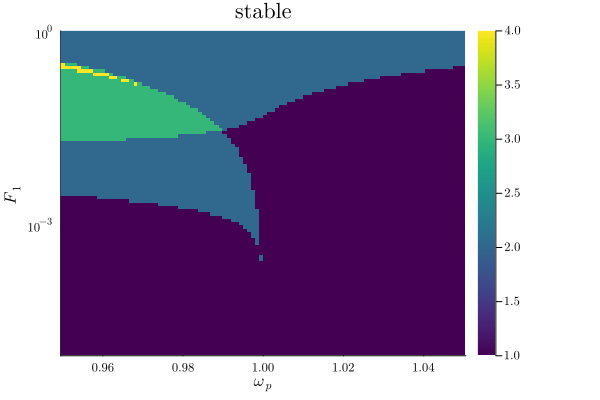

In [32]:
# p1 = plot_phase_diagram(result, title="all", clim =(0,5), yaxis=:log)
p2 = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:log)
# p3 = plot_phase_diagram(result, not_class="stable", title="unstable", clim =(0,5), yaxis=:log)
# p_MF = plot([p1,p2,p3]..., layout = (1,3), size = (1200,250), margin = 5mm)

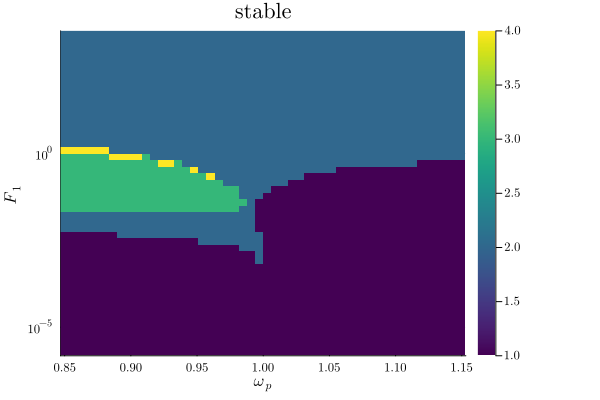

In [19]:
# fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val)
# varied = (ω_p=> range(0.85, 1.15, 50), F_1 => 14 .^range(-5, 3, 50))

# # results
# result_tmp = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true, random_warmup=false)

# plot_phase_diagram(result_tmp, class="stable", title="stable", yaxis=:log)

### Amplitude plot

#### linear

In [33]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:linear);

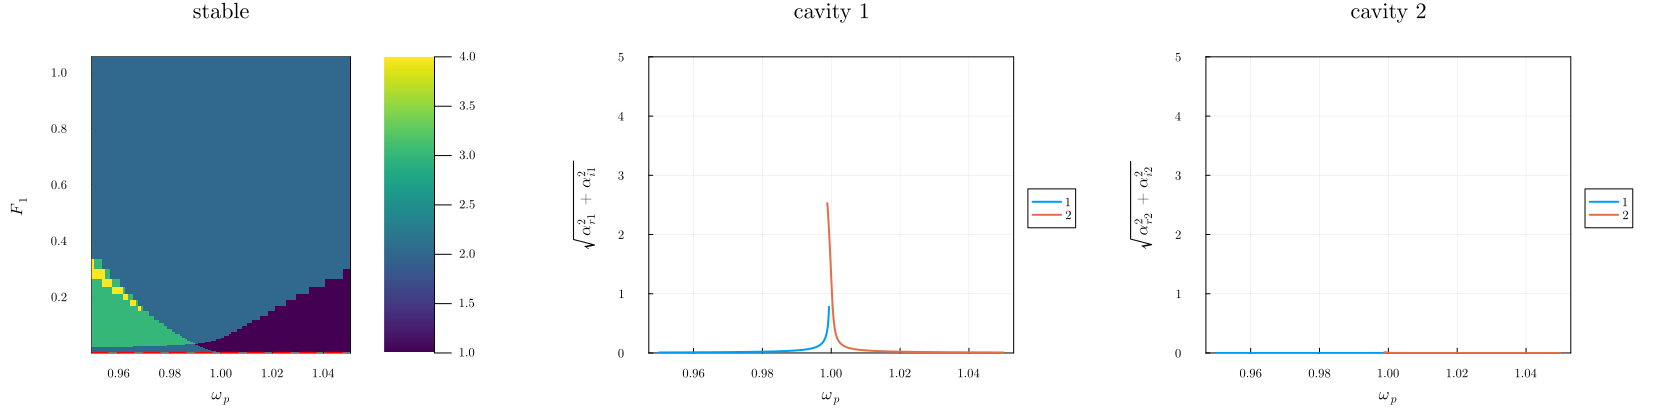

In [50]:
f_cut = 0.00044; yscale = :linear; class = "stable"; ymax = 5

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1")
p3 = plot(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

[Antiresoncance](https://en.wikipedia.org/wiki/Antiresonance)

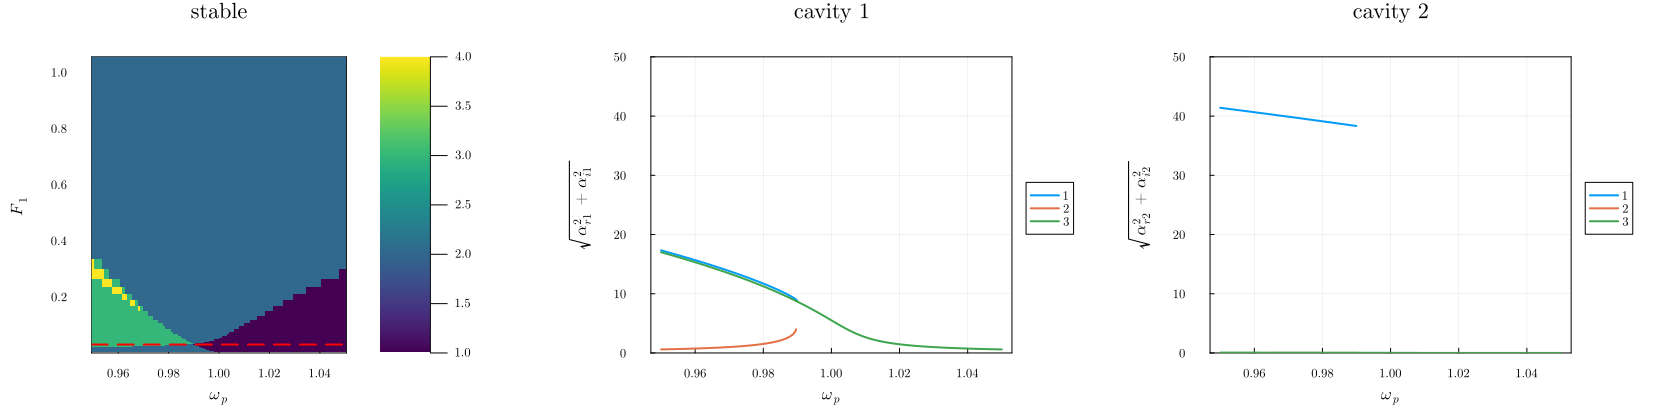

In [52]:
f_cut = 0.03; yscale = :linear; class = "stable"; ymax=50

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box, yminorticks=true)
p2 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1")
p3 = plot(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

#### log

In [53]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:log);

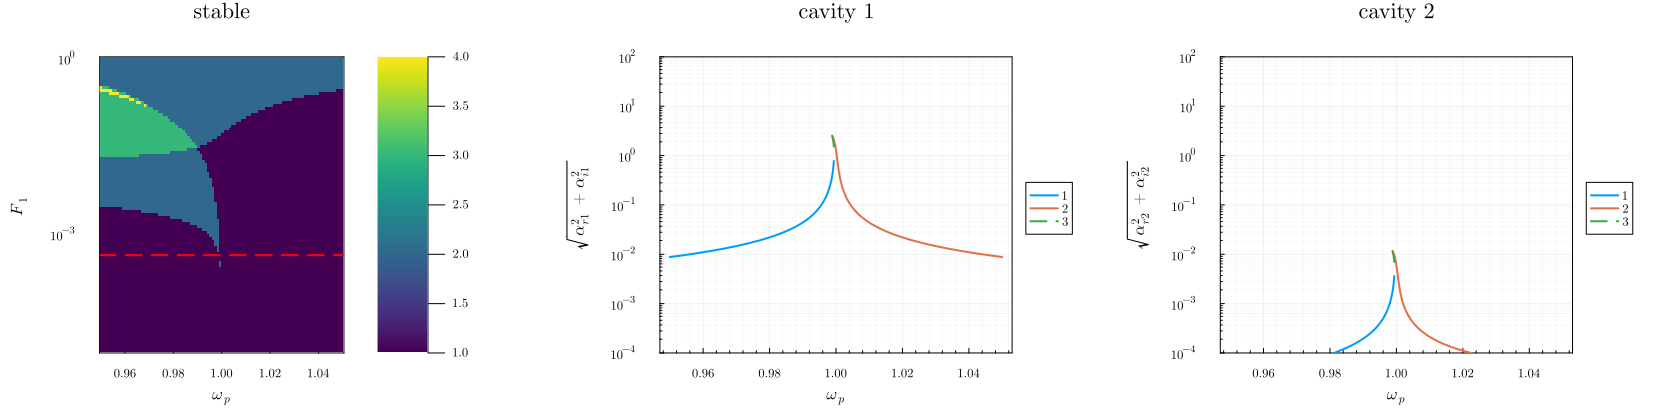

In [54]:
f_cut = 0.00044; yscale = :log10; class = "default"; ymax = 100

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box, yminorticks=10)
p2 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-4,ymax), yminorticks=10, minorgrid=true, title="cavity 1")
p3 = plot(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-4,ymax), yminorticks=10, minorgrid=true, title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

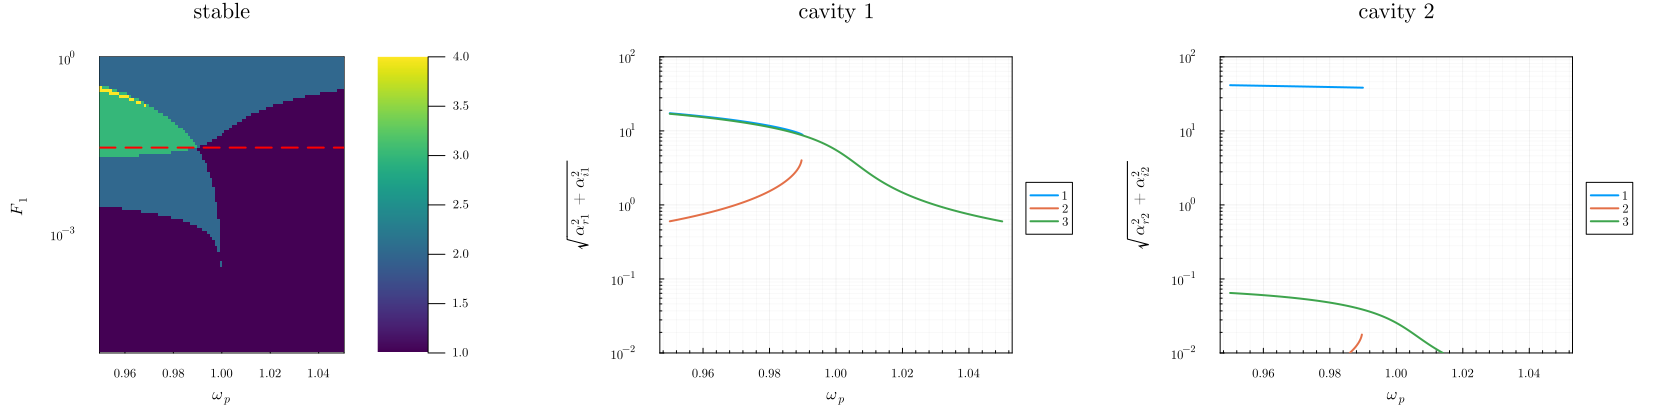

In [56]:
f_cut = 0.03; yscale = :log; class = "stable"; ymax=100

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box, yminorticks=10)
p2 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-2,ymax), yminorticks=10, minorgrid=true, title="cavity 1")
p3 = plot(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-2,ymax), yminorticks=10, minorgrid=true, title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

### Phase plot

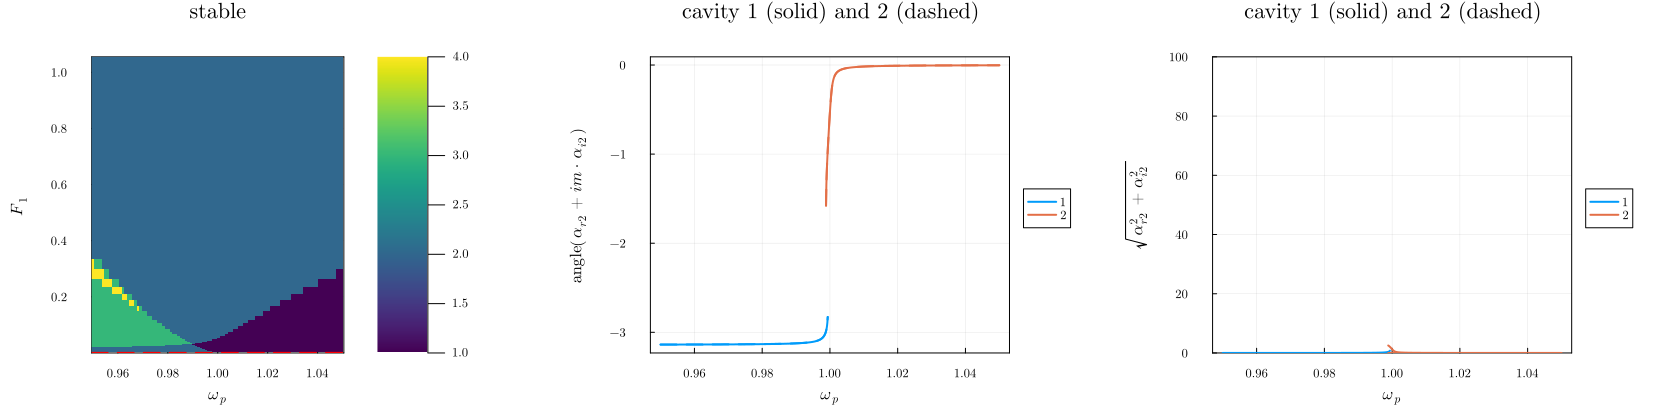

In [57]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:linear);
f_cut = 0.00044; yscale = :linear; class = "stable"

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "angle(αᵣ₁+im*αᵢ₁)", class=class, yscale=yscale, framestyle = :box, title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "angle(αᵣ₂+im*αᵢ₂)", class=class, yscale=yscale, framestyle = :box, linestyle=:dash)
p3 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), linestyle=:dash)
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

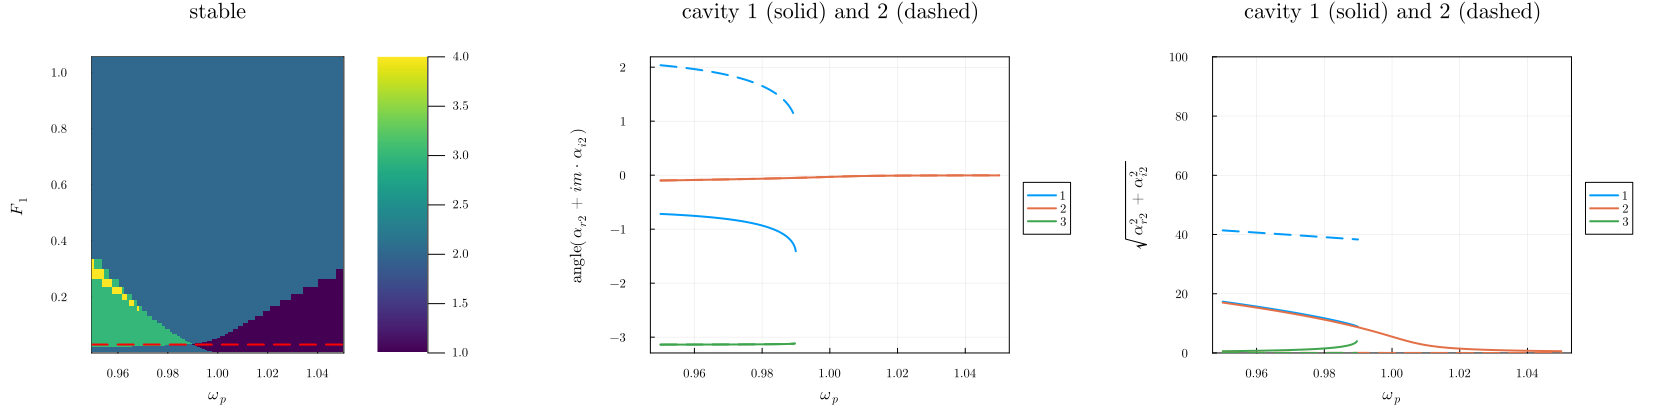

In [58]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:linear);
f_cut = 0.03; yscale = :linear; class = "stable"

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "angle(αᵣ₁+im*αᵢ₁)", class=class, yscale=yscale, framestyle = :box, title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "angle(αᵣ₂+im*αᵢ₂)", class=class, yscale=yscale, framestyle = :box, linestyle=:dash)
p3 = plot(result_ω1, y = "√(αᵣ₁^2+αᵢ₁^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "√(αᵣ₂^2+αᵢ₂^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), linestyle=:dash)
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)